In [1]:
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 符号付に変換する関数
def unsigned2signed(x):
    if x > 32767:
        return x - 65536
    return x

In [3]:
# 学習データの読み込み
def load_binary_data(folder_path):
    data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in data or data_index > data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    file_names.append(file_name)  # ファイル名をリストに追加

    return data, file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# フォルダを選択するためのダイアログを表示
folder_selected = filedialog.askdirectory()

if folder_selected:
    print("選択したフォルダ:", folder_selected)
    # フォルダ内のデータを読み込む
    data, data_filenames = load_binary_data(folder_selected)
    if data:
        print("データの読み込みが完了しました。")
    else:
        print("データが見つかりませんでした。")
else:
    print("フォルダが選択されませんでした。")

# Tkinterを終了
root.quit()

sensor_data_dict = {}  # センサーデータを格納するディクショナリ
for key, sensor_data in data.items():
    extension_number = sensor_data[-1]  # 拡張子の番号
    for i, sensor_value in enumerate(sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if sensor_key not in sensor_data_dict:
            sensor_data_dict[sensor_key] = []  # キーが存在しない場合、空のリストを作成
        sensor_data_dict[sensor_key].append(sensor_value)  # キーに対応するリストにセンサーデータを追加

# データの形状を決定
num_samples = len(sensor_data_dict)
num_sensors = 8  # センサーの数

# 2次元のリストを初期化
data_matrix = [[None] * num_sensors for _ in range(num_samples)]

# センサーデータのみを保存する新しい変数を作成
sensor_data = []

# データを2次元リストと新しい変数に配置
for i, (key, sensor_values) in enumerate(sensor_data_dict.items()):
    data_matrix[i] = [key] + sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    sensor_data.append(sensor_values)  # センサーデータのリストを新しい変数に格納

# data_matrix には各キー（インデックス）に対応するセンサーデータが格納されています
# sensor_data にはセンサーデータのリストのみが格納されています

選択したフォルダ: C:/Users/r-fujita/Desktop/FCC_E-2316B
データの読み込みが完了しました。


In [4]:
# テストデータの読み込み
def load_test_data(test_folder_path):
    test_data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    test_file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(test_folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in test_data or data_index > test_data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    test_data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    test_file_names.append(file_name)  # ファイル名をリストに追加

    return test_data, test_file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# テストデータのフォルダを選択するためのダイアログを表示
test_folder_path = filedialog.askdirectory()

if test_folder_path:
    print("選択したテストデータのフォルダ:", test_folder_path)
    # テストデータを読み込む
    test_data, test_data_filenames = load_test_data(test_folder_path)
    if test_data:
        print("テストデータの読み込みが完了しました。")
    else:
        print("テストデータが見つかりませんでした.")
else:
    print("テストデータのフォルダが選択されませんでした.")

test_sensor_data_dict = {}  # テストデータのセンサーデータを格納するディクショナリ
for key, test_sensor_data in test_data.items():
    extension_number = test_sensor_data[-1]  # 拡張子の番号
    for i, test_sensor_value in enumerate(test_sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        test_sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if test_sensor_key not in test_sensor_data_dict:
            test_sensor_data_dict[test_sensor_key] = []  # キーが存在しない場合、空のリストを作成
        test_sensor_data_dict[test_sensor_key].append(test_sensor_value)  # キーに対応するリストにテストデータのセンサーデータを追加

# データの形状を決定
num_test_samples = len(test_sensor_data_dict)
num_sensors = 8  # センサーの数

# テストデータの2次元のリストを初期化
test_data_matrix = [[None] * num_sensors for _ in range(num_test_samples)]

# テストデータのセンサーデータのみを保存する新しい変数を作成
test_sensor_data = []

# テストデータを2次元リストと新しい変数に配置
for i, (key, test_sensor_values) in enumerate(test_sensor_data_dict.items()):
    test_data_matrix[i] = [key] + test_sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    test_sensor_data.append(test_sensor_values)  # テストデータのセンサーデータのリストを新しい変数に格納

# test_data_matrix には各キー（インデックス）に対応するテストデータのセンサーデータが格納されています
# test_sensor_data にはテストデータのセンサーデータのリストのみが格納されています

選択したテストデータのフォルダ: C:/Users/r-fujita/Desktop/テストデータ_FCC_E-2316A
テストデータの読み込みが完了しました。


In [6]:
# データの標準化
# 学習データ
sensor_data_sca = []
for i in range(len(sensor_data)):
    mean = np.mean(sensor_data[i])
    std = np.std(sensor_data[i])

    #標準化処理を実行
    standardization_sensor_data = (sensor_data[i] - mean) / std
    sensor_data_sca.append(standardization_sensor_data)

# テストデータ
test_sensor_data_sca = []
for i in range(len(test_sensor_data)):
    mean = np.mean(test_sensor_data[i])
    std = np.std(test_sensor_data[i])

    #標準化処理を実行
    standardization_test_sensor_data = (test_sensor_data[i] - mean) / std
    test_sensor_data_sca.append(standardization_test_sensor_data)


# データ長を揃える
# 最大の波形データ長を見つける
max_length = max(max(len(waveform) for waveform in sensor) for sensor in sensor_data_sca + test_sensor_data_sca)

# ゼロパディングを行う
padded_sensor_data = []
for sensor in sensor_data_sca:
    padded_sensor = []
    for waveform in sensor:
        # ゼロパディング
        padding = [0] * (max_length - len(waveform))
        padded_waveform = np.concatenate((waveform, padding)) if len(padding) > 0 else waveform
        padded_sensor.append(padded_waveform)
    padded_sensor_data.append(padded_sensor)

# 同じことをtest_sensor_dataにも適用
padded_test_sensor_data = []
for sensor in test_sensor_data_sca:
    padded_sensor = []
    for waveform in sensor:
        # ゼロパディング
        padding = [0] * (max_length - len(waveform))
        padded_waveform = np.concatenate((waveform, padding)) if len(padding) > 0 else waveform
        padded_sensor.append(padded_waveform)
    padded_test_sensor_data.append(padded_sensor)

# 学習データとテストデータをNumPyの配列に変換
padded_sensor_data = np.array(padded_sensor_data)
padded_test_sensor_data = np.array(padded_test_sensor_data)

# 中間の次元（次元1）を削除して2次元に reshape
padded_sensor_data = np.squeeze(padded_sensor_data, axis=1)
padded_test_sensor_data = np.squeeze(padded_test_sensor_data, axis=1)

# 管ごとの8チャンネルのデータを結合
concatenated_data_per_subject = []
for i in range(len(padded_sensor_data) // 8):  # 管の数だけループ
    subject_data = padded_sensor_data[i * 8:(i + 1) * 8]  # 同じ管の8チャンネルのデータを取得
    concatenated_data = np.stack(subject_data, axis=-1)  # 8チャンネルのデータを1つの配列に連結
    concatenated_data_per_subject.append(concatenated_data)

# データをデータ長×8チャンネルの形状に整形する
reshaped_sensor_data = []
for data in concatenated_data_per_subject:
    reshaped_sensor_data.append(data.reshape(-1, 8))  # データ長×8チャンネルの形状に変換し、リストに追加

reshaped_sensor_data = np.array(reshaped_sensor_data)  # リストをNumPy配列に変換

# 管ごとの8チャンネルのデータを結合
concatenated_data_per_subject = []
for i in range(len(padded_test_sensor_data) // 8):  # 管の数だけループ
    subject_data = padded_test_sensor_data[i * 8:(i + 1) * 8]  # 同じ管の8チャンネルのデータを取得
    concatenated_data = np.stack(subject_data, axis=-1)  # 8チャンネルのデータを1つの配列に連結
    concatenated_data_per_subject.append(concatenated_data)

# データをデータ長×8チャンネルの形状に整形する
reshaped_test_sensor_data = []
for data in concatenated_data_per_subject:
    reshaped_test_sensor_data.append(data.reshape(-1, 8))  # データ長×8チャンネルの形状に変換し、リストに追加

reshaped_test_sensor_data = np.array(reshaped_test_sensor_data)  # リストをNumPy配列に変換


In [20]:
def stacked_what_where_autoencoder(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(32, 3, activation='selu', padding='same')(inputs)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)  # 時間軸方向のみにプーリングを行う
    conv2 = Conv1D(64, 3, activation='selu', padding='same')(pool1)
    pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)  # 時間軸方向のみにプーリングを行う

    # Decoder
    up1 = UpSampling1D(2)(pool2)
    conv3 = Conv1DTranspose(32, 3, activation='selu', padding='same')(up1)
    up2 = UpSampling1D(2)(conv3) 
    decoded = Conv1DTranspose(input_shape[-1], 3, activation='selu', padding='same')(up2)

    # Autoencoder Model
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [21]:
# 入力データの形状を取得
input_shape = reshaped_sensor_data.shape[1:]
# Stacked What-Where Autoencoderを構築
autoencoder = stacked_what_where_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# モデルのサマリを表示
autoencoder.summary()

# モデルの学習
history = autoencoder.fit(reshaped_sensor_data, reshaped_sensor_data, epochs=10, batch_size=16, shuffle=True, verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14784, 8)]        0         
                                                                 
 conv1d_6 (Conv1D)           (None, 14784, 32)         800       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 7392, 32)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 7392, 64)          6208      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 3696, 64)         0         
 1D)                                                             
                                                                 
 up_sampling1d_6 (UpSampling  (None, 7392, 64)         0   

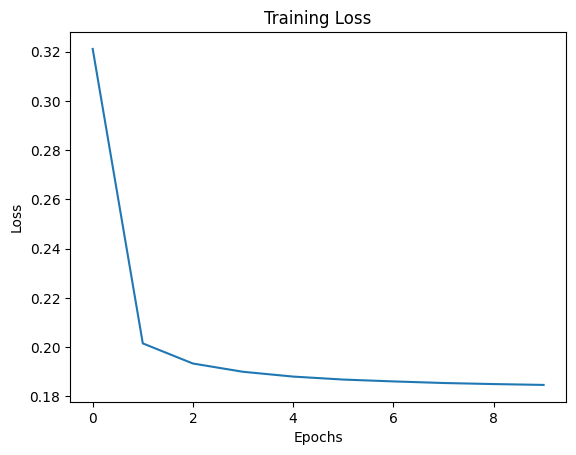

<Figure size 640x480 with 0 Axes>

In [22]:
# 損失関数の値を取得
loss = history.history['loss']

# エポックごとの損失関数の変化をプロット
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 画像として保存
plt.savefig('training_loss.png')  # 任意のファイル名と拡張子を指定して保存

In [ ]:
# テストデータを使って再構築を行う
reconstructed_test_data = autoencoder.predict(reshaped_test_sensor_data)

In [30]:
# 学習データの再構成を行う
# テストデータに対する再構築を行う
reconstructed_data = autoencoder.predict(reshaped_sensor_data)

27/27 [==============================] - 1s 24ms/step


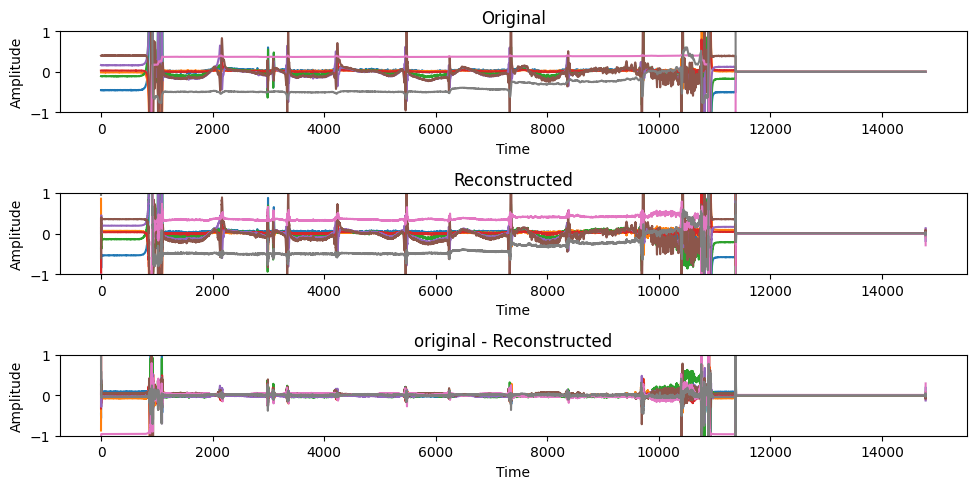

In [58]:
# データをプロットして可視化
import matplotlib.pyplot as plt

n = 20 # 表示するデータ
ch = 1 # 表示するチャンネル
plt.figure(figsize=(10, 5))

# オリジナルのデータをプロット
ax = plt.subplot(3, 1, 1)
plt.plot(reshaped_test_sensor_data[n,:,:])
plt.title("Original")
plt.ylim(-1,1)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# 再構築されたデータをプロット
ax = plt.subplot(3, 1, 2)
plt.plot(reconstructed_test_data[n,:,:])
plt.title("Reconstructed")
plt.ylim(-1,1)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# オリジナル-再構築
ax = plt.subplot(3, 1, 3)
plt.plot(reshaped_test_sensor_data[n,:,:] - reconstructed_test_data[n,:,:])
plt.title("original - Reconstructed")
plt.ylim(-1,1)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

plt.tight_layout()
plt.show()


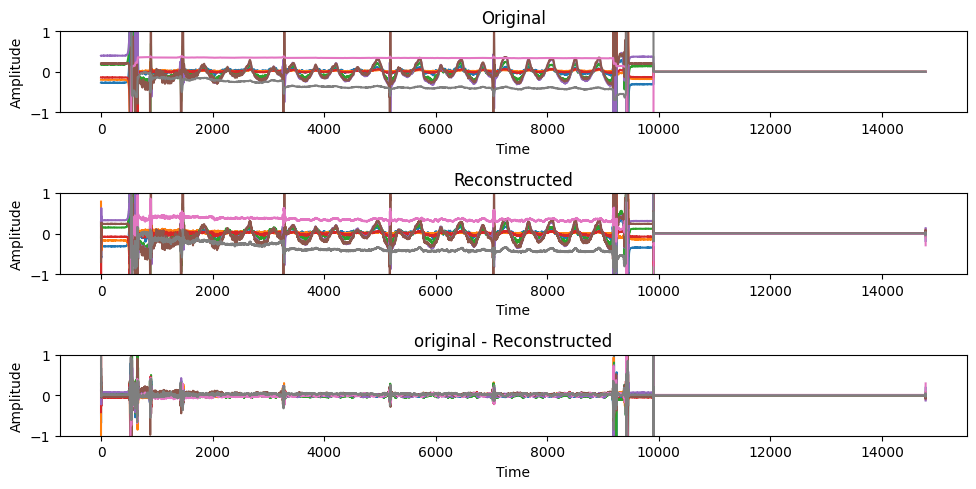

In [47]:
# いくつかのデータをプロットして可視化

n = 1 # 表示するデータ
ch = 1 # 表示するチャンネル
plt.figure(figsize=(10, 5))

# オリジナルのデータをプロット
ax = plt.subplot(3, 1, 1)
plt.plot(reshaped_sensor_data[n,:,:])
plt.title("Original")
plt.ylim(-1,1)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# 再構築されたデータをプロット
ax = plt.subplot(3, 1, 2)
plt.plot(reconstructed_data[n,:,:])
plt.title("Reconstructed")
plt.ylim(-1,1)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

# オリジナル-再構築
ax = plt.subplot(3, 1, 3)
plt.plot(reshaped_sensor_data[n,:,:] - reconstructed_data[n,:,:])
plt.title("original - Reconstructed")
plt.ylim(-1,1)
plt.xlabel('Time')  # x軸ラベル
plt.ylabel('Amplitude')  # y軸ラベル

plt.tight_layout()
plt.show()


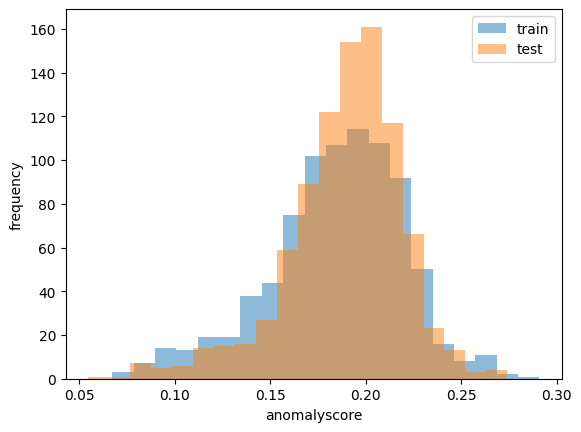

In [35]:
# 学習データの再構築誤差（平均二乗誤差）の計算
mse = np.mean(np.square(reshaped_sensor_data - reconstructed_data), axis=(1, 2))  # データごとの平均二乗誤差を計算
# テストデータの再構築誤差（平均二乗誤差）の計算
mse_test = np.mean(np.square(reshaped_test_sensor_data - reconstructed_test_data), axis=(1, 2))  # データごとの平均二乗誤差を計算

# ヒストグラムの作成
# 学習データのヒストグラム
plt.hist(mse, bins=20, alpha=0.5, label='train')  # 学習データのヒストグラムをプロット

# テストデータのヒストグラム
plt.hist(mse_test, bins=20, alpha=0.5, label='test')  # テストデータのヒストグラムをプロット

plt.xlabel('anomalyscore')
plt.ylabel('frequency')
plt.legend()  # 凡例を表示
plt.show()

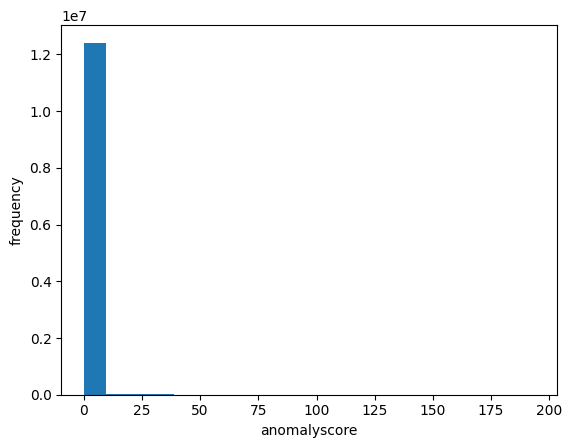

In [49]:
# 各データポイントごとの平均二乗誤差を計算
pointwise_mse = np.mean(np.square(reshaped_sensor_data - reconstructed_data), axis=2)  # 各データポイントごとの平均二乗誤差を計算

# データポイントごとの平均二乗誤差を1次元配列に変換
pointwise_mse_flattened = pointwise_mse.flatten()

# ヒストグラムの作成
import matplotlib.pyplot as plt

plt.hist(pointwise_mse_flattened, bins=20)  # 各データポイントの誤差のヒストグラムを作成
plt.xlabel('anomalyscore')
plt.ylabel('frequency')
plt.show()
